In [1]:
import sys,math,pdb,time,re
from pathlib import Path
sys.path.append(str(Path("./")))

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as dspl

import torch
import torchvision
import torchvision.transforms as transforms

from utils import gadget,nn_fn

In [2]:
'''Specify Data loader'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x:x.repeat(3,1,1)) ,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
BATCH_SIZE = 64

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(mnist_train, [55000, 5000])
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          pin_memory=True,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset,
                                          batch_size=BATCH_SIZE,
                                          pin_memory=True,
                                          shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE*4,
                                          pin_memory=True,
                                          shuffle=False)

/home/jovyan/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
plt_x,plt_y=next(iter(testloader))
(plt_x,plt_y) = [t.cuda() for t in (plt_x,plt_y) if t is not None]

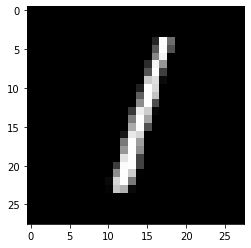

In [4]:
# %matplotlib widget
idx=2
plt.imshow(plt_x[idx].cpu().numpy().transpose(1,2,0)/2+0.5)

In [5]:
model=nn_fn.ClasModel(3,10,latent_features=2,hidden_featrues=128,mode="dense").cuda()
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, 1*len(trainset)//BATCH_SIZE, 1)
# criterion=torch.nn.CrossEntropyLoss()
criterion=nn_fn.FocalLoss(3)

In [6]:
EPOCHS=10
weigh_norm=[]
latent_norm=[]
loss_mean_buff=[]
acc_mean_buff=[]
vloss_mean_buff=[]
vacc_mean_buff=[]

rec_dense=gadget.Rec()
word_display=dspl.display("",display_id=2)
n_samples=0
for ee in range(EPOCHS):
    for ii,(x,y) in enumerate(trainloader):
        (x,y) = [t.cuda() for t in (x,y) if t is not None]
        opt.zero_grad()
        pred,hiddens =model(x,y)
        latent=hiddens[-1]
        loss = criterion(pred, y)
        acc=gadget.mean_acc(pred,y)

        loss.backward()
        opt.step()
        scheduler.step()

        with torch.no_grad():
            weigh_norm=torch.norm(model.out_net.weight,2).item()
            latent_norm=torch.norm(latent,2).item()
            loss_mean_buff=(loss_mean_buff*ii+loss.item())/(ii+1) if ii>0 else loss.item()
            acc_mean_buff=(acc_mean_buff*ii+acc)/(ii+1) if ii>0 else acc

            gadget.show_progress(n_samples,display_id=2,
                epoch=ee,session="train",
                loss=loss_mean_buff,acc=acc_mean_buff,
                weight=weigh_norm,latent=latent_norm)

            if n_samples%200==199:
                _,hiddens =model(plt_x)
                
                rec_dense.append(hiddens[-1],plt_y,n_samples+1)
            n_samples+=1

"['epoch:9', 'session:train', 'loss:0.0010', 'acc:0.9679', 'weight:2.6228', 'latent:126.9831']"

/home/jovyan/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
rec_dense.normalize()

In [9]:
fig=rec_dense.__repr__()
%mkdir history
fig.write_html("history/dense.html")

mkdir: cannot create directory ‘history’: File exists


In [11]:
rec_dense.df.to_csv("history/dense_latent.csv")
torch.save(model.state_dict,"history/dense.pt")